Let's explore the gradients of the EventProp algorithm in jax on a single LIF Neuron with one spike.

In [ ]:
from jaxsnn.event.leaky_integrate_and_fire import LIFParameters, LIFState, StepState
from jaxsnn.base.types import InputQueue
from jaxsnn.event.root import ttfs_solver
import jax.numpy as np
import jax
import matplotlib.pyplot as plt
from jaxsnn.base.types import EventPropSpike, Spike, Weight, WeightRecurrent, WeightInput
from functools import partial
from jaxsnn.event.loss import first_spike
from jax.config import config
from jax import lax
from jaxsnn.event import custom_lax

config.update("jax_debug_nans", True)

p = LIFParameters()

single_solver = partial(ttfs_solver, p.tau_mem, p.v_th)

def lif_flow(x0, t: float):
    return np.dot(jax.scipy.linalg.expm(p.dynamics * t), x0)


def wrapped_dynamics(neuron_state: LIFState, t: float):
    x0 = np.array([neuron_state.V, neuron_state.I])
    x1 = lif_flow(x0, t)
    return LIFState(V=x1[0], I=x1[1])

: 

First, we check the gradient for a single input spike at time t = 0.0 with a current of magnitude $w_{ij}$

In [2]:
def ttfs(w_ij):
    x0 = np.array([0.0, w_ij])
    return single_solver(LIFState(V=x0[0], I=x0[1]), dt=1.0)

jax.grad(ttfs)(3.0)

DeviceArray(-0.00206011, dtype=float32, weak_type=True)

Next, we define the dynamics for the adjoint variables

In [3]:
def free_adjoint_dynamics(lambda_0, t):
    A = np.array([[-p.tau_mem_inv, 0.0], [p.tau_syn_inv, -p.tau_syn_inv]])
    return np.dot(jax.scipy.linalg.expm(A * t), lambda_0)   


def lif_adjoint_dynamics(lambda_0, t):
    tau_exp = np.exp(-t / p.tau_mem)
    syn_exp = np.exp(-t / p.tau_syn)
    A = np.array([[tau_exp, 0], [p.tau_mem / (p.tau_mem - p.tau_syn) * (tau_exp - syn_exp), tau_exp]])
    return np.dot(A, lambda_0)


def wrapped_adjoint_dynamics(neuron_state: LIFState, t: float):
    x0 = np.array([neuron_state.V, neuron_state.I])
    x1 = free_adjoint_dynamics(x0, t)
    return LIFState(V=x1[0], I=x1[1])

Plot the adjoint dynamics backward in time

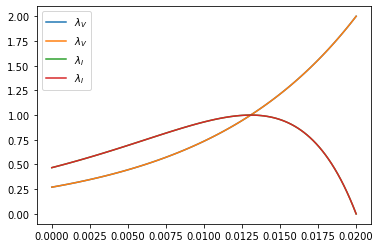

In [4]:
lambda_0 = np.array([2.0, 0.0])
ts = np.linspace(0, 0.02, 100)

lambda_t = jax.vmap(free_adjoint_dynamics, in_axes=(None, 0))(lambda_0, ts)
lambda_t2 = jax.vmap(lif_adjoint_dynamics, in_axes=(None, 0))(lambda_0, ts)

# dynamic is backward in time
lambda_t = lambda_t[::-1]
lambda_t2 = lambda_t2[::-1]

plt.plot(ts, lambda_t[:, 0], label=r"$\lambda_V$")
plt.plot(ts, lambda_t2[:, 0], label=r"$\lambda_V$")

plt.plot(ts, lambda_t[:, 1], label=r"$\lambda_I$")
plt.plot(ts, lambda_t2[:, 1], label=r"$\lambda_I$")
plt.legend()
plt.show()

Let's see if we get the same gradient if we write the EventProp algorithm for a single event.

In [5]:
t_max = 1.0

def ttfs(w_ij):
    x0 = np.array([0.0, w_ij])
    t_spike = single_solver(LIFState(V=x0[0], I=x0[1]), dt=t_max)
    return t_spike

def f_fwd(w_ij):
    t_spike = ttfs(w_ij)

    x0 = np.array([0.0, w_ij])
    x1 = lif_flow(x0, t_spike)
    return t_spike, (w_ij, x1[1], t_spike)


def f_bwd(res, g):
    w_ij, current, t_spike = res
    lambda_V, lambda_I = 0.0, 0.0

    if t_spike == t_max:
        return (0.0,)

    # bump the adjoint variables at the time of spike
    lambda_V = lambda_V + 1 / (current - p.v_th) * g

    # integrate lambdas to input event
    adjoint_state = free_adjoint_dynamics(np.array([lambda_V, lambda_I]), t_spike)
    lambda_I = adjoint_state[1]

    # propagate information backwards at the time of the input spike
    return (-p.tau_syn * lambda_I, )


ttfs_eventprop = jax.custom_vjp(ttfs)
ttfs_eventprop.defvjp(f_fwd, f_bwd)

In [6]:
value, grad = jax.value_and_grad(ttfs)(3.0)
print(f"Analytical gradient: Time of spike: {value:.6f}, grad: {grad:.6f}")
value, grad = jax.value_and_grad(ttfs_eventprop)(3.0)
print(f"EventProp gradient: Time of spike: {value:.6f}, grad: {grad:.6f}")

Analytical gradient: Time of spike: 0.003235, grad: -0.002060
EventProp gradient: Time of spike: 0.003235, grad: -0.002060


Let's explore what happens closer to the point where the bump is not defined.

In [7]:
value, grad = jax.value_and_grad(ttfs)(3.0)
print(f"Analytical gradient: Time of spike: {value:.6f}, grad: {grad:.6f}")
value, grad = jax.value_and_grad(ttfs_eventprop)(3.0)
print(f"EventProp gradient: Time of spike: {value:.6f}, grad: {grad:.6f}")

Analytical gradient: Time of spike: 0.003235, grad: -0.002060
EventProp gradient: Time of spike: 0.003235, grad: -0.002060


So for one neuron and one spike, the gradients match up. Let's do it for multiple input neurons and one input spike at t=0

In [8]:
def ttfs(params, input_spike: Spike):
    x0 = np.array([0.0, params[input_spike.idx]])
    t_spike = single_solver(LIFState(V=x0[0], I=x0[1]), dt=t_max)
    return t_spike


def f_fwd(params, input_spike: Spike):
    t_spike = ttfs_eventprop(params, input_spike)

    x0 = np.array([0.0, params[input_spike.idx]])
    x1 = lif_flow(x0, t_spike)
    return t_spike, (params, x1[1], t_spike, input_spike)


def f_bwd(res, g):
    params, current, t_spike, input_spike = res
    lambda_V, lambda_I = 0.0, 0.0

    if t_spike == t_max:
        return (0.0, )

    lambda_V = lambda_V + 1 / (current - p.v_th) * g

    # integrate lambdas to next event
    adjoint_state = free_adjoint_dynamics(np.array([lambda_V, lambda_I]), t_spike)
    lambda_I = adjoint_state[1]

    # grad_ji <- grad_ji - \tau_s lambda_I
    # sum over input spikes, but there is only one :)
    grad = np.zeros(params.shape[0])
    grad = grad.at[input_spike.idx].add(-p.tau_syn * lambda_I)
    return grad, input_spike 

ttfs_eventprop = jax.custom_vjp(ttfs)
ttfs_eventprop.defvjp(f_fwd, f_bwd)

In [9]:
input_spike = Spike(time=np.array(0.0), idx=np.array(2))
params = np.full(4, 3.0)
value, grad = jax.value_and_grad(ttfs_eventprop)(params, input_spike)
print(f"Analytical gradient: Time of spike: {value:.6f}, grad: {grad}")
value, grad = jax.value_and_grad(ttfs)(params, input_spike)
print(f"EventProp gradient: Time of spike: {value:.6f}, grad: {grad}")

Analytical gradient: Time of spike: 0.003235, grad: [ 0.          0.         -0.00206011  0.        ]
EventProp gradient: Time of spike: 0.003235, grad: [ 0.          0.         -0.00206011  0.        ]


We have checked that the gradients calculated by the EventProp algorith work for one layer with multiple input neurons. We now move on to:

* Multiple neurons per layer
* Multiple layers

In order to propagate information between layers, we need to populate information in the `input_queue` of the `adjoint_state`.

In [10]:
def adjoint_transition_in_layer_no_recurrency(
    p: LIFParameters,
    adjoint_state: StepState,
    spike: EventPropSpike,
    layer_start: int,
    adjoint_spike: EventPropSpike,
    grads: WeightInput,
    params: WeightInput,
    input_queue_head: int,
):
    epsilon = 1e-6
    safe_denominator = np.where(
        np.abs(spike.current - p.v_th) > epsilon, spike.current - p.v_th, epsilon
    )
    adjoint_state.neuron_state.V = adjoint_state.neuron_state.V.at[
        spike.idx - layer_start
    ].add(adjoint_spike.time / safe_denominator)
    return adjoint_state, grads


def adjoint_input_transition(
    p: LIFParameters,
    adjoint_state: StepState,
    spike: EventPropSpike,
    layer_start: int,
    adjoint_spike: EventPropSpike,
    grads: WeightInput,
    params: WeightInput,
    input_queue_head: int,
):
    prev_layer_start = layer_start - params.input.shape[0]
    index_for_layer = spike.idx - prev_layer_start

    # do nothing if spike is not from directly previous layer
    grads, dt = lax.cond(
        index_for_layer >= 0,
        lambda: (
            WeightInput(
                grads.input.at[index_for_layer].add(
                    -p.tau_syn * adjoint_state.neuron_state.I
                ),
            ),
            np.dot(
                params.input[index_for_layer],
                (adjoint_state.neuron_state.V - adjoint_state.neuron_state.I),
            ),
        ),
        lambda: (grads, 0.0),
    )
    adjoint_state.input_queue.spikes.time = adjoint_state.input_queue.spikes.time.at[
        input_queue_head - 1
    ].set(dt)
    adjoint_state.input_queue.head += 1
    return adjoint_state, grads


def adjoint_transition_no_recurrency(
    p: LIFParameters,
    adjoint_state: StepState,
    spike: EventPropSpike,
    layer_start: int,
    adjoint_spike: EventPropSpike,
    grads: WeightInput,
    params: WeightInput,
    input_queue_head: int,
):
    spike_in_layer = spike.idx >= layer_start
    return lax.cond(
        spike_in_layer,
        adjoint_transition_in_layer_no_recurrency,
        adjoint_input_transition,
        *(
            p,
            adjoint_state,
            spike,
            layer_start,
            adjoint_spike,
            grads,
            params,
            input_queue_head,
        ),
    )

In [11]:
from jaxsnn.event.leaky_integrate_and_fire import transition_without_recurrence
from jaxsnn.event.functional import step


tr_dynamics = partial(transition_without_recurrence, p)
adjoint_tr_dynamics = partial(adjoint_transition_no_recurrency, p)

solver = jax.vmap(single_solver, in_axes=(0, None))
dynamics = jax.vmap(wrapped_dynamics, in_axes=(0, None))
adjoint_dynamics = jax.vmap(wrapped_adjoint_dynamics, in_axes=(0, None))

step_fn = partial(step, dynamics, tr_dynamics, t_max, solver)

In [12]:
def step_fn_fwd(input, iteration: int):
    ((state, params, layer_start), spike) = step_fn(input, iteration)
    return ((state, params, layer_start), spike), (
        spike,
        params,
        layer_start,
        state.input_queue.head,
    )


def step_fn_bwd(res, g):
    spike, params, layer_start, input_queue_head = res
    (adjoint_state, grads, _), adjoint_spike = g

    reversed_time = t_max - spike.time
    time_diff = reversed_time - adjoint_state.time

    # integrate lambdas to the spike
    adjoint_state.neuron_state = adjoint_dynamics(
        adjoint_state.neuron_state, time_diff
    )
    adjoint_state.time = reversed_time

    no_event = spike.idx == -1
    tr_state, new_grads = lax.cond(
        no_event,
        lambda *args: (adjoint_state, grads),
        adjoint_tr_dynamics,
        *(
            adjoint_state,
            spike,
            layer_start,
            adjoint_spike,
            grads,
            params,
            input_queue_head,
        )
    )
    return (tr_state, new_grads, layer_start), 1


def forward(apply_fn, n_spikes: int, params: Weight, input_spikes: EventPropSpike, layer_start: int) -> EventPropSpike:
    n_neurons = params.input.shape[1]
    initial_state = LIFState(np.zeros(n_neurons), np.zeros(n_neurons))
    s = StepState(
        neuron_state=initial_state, time=0.0, input_queue=InputQueue(input_spikes)
    )
    _, spikes = lax.scan(apply_fn, (s, params, layer_start), np.arange(n_spikes))
    return spikes


# define custom vjp
step_event_prop = jax.custom_vjp(step_fn)
step_event_prop.defvjp(step_fn_fwd, step_fn_bwd)

In [13]:
from jaxsnn.event.loss import mse_loss


def loss(apply_fn, params, batch):
    prev_neurons = 0
    spikes, target = batch
    for layer_params in params:
        prev_neurons += layer_params.input.shape[0]
        spikes = apply_fn(layer_params, spikes, prev_neurons)

    output_neurons = params[-1].input.shape[1]
    n_neurons = prev_neurons + output_neurons
    output_spikes = first_spike(spikes, n_neurons)[prev_neurons: ]
    return mse_loss(output_spikes, target, p.tau_mem), output_spikes

In [14]:
# define input spikes
input =  EventPropSpike(time=np.array([0.0, 1e-4]), idx=np.array([0, 1]), current=np.array([0.0, 0.0]))
target = np.array([0.5 * p.tau_syn, 1.0 * p.tau_syn])
batch = (input, target)
n_spikes = 6

# init params
params = [WeightInput(np.array([[1.0, 2.0, 3.0], [1.0, 2.0, 3.0]])), WeightInput(np.array([[2.0, 3.0], [2.0, 3.0], [2.0, 3.0]]))]

# and run
(loss_value, output_spikes), grad = jax.value_and_grad(partial(loss, partial(forward, step_fn, n_spikes)), has_aux=True)(params, batch)
print(f"Analytical gradient: Loss value: {loss_value:.6f}, grad: \n{grad[0].input},\n {grad[1].input}")

(loss_value, output_spikes), grad = jax.value_and_grad(partial(loss, partial(forward, step_event_prop, n_spikes)), has_aux=True)(params, batch)
print(f"\nEventProp gradient: Loss value: {loss_value:.6f}, grad: \n{grad[0].input},\n {grad[1].input}")

print(f"Output spikes: {output_spikes}")

Analytical gradient: Loss value: 3.107546, grad: 
[[0.         0.01034393 0.01530054]
 [0.         0.009994   0.01482641]],
 [[0.         0.        ]
 [0.         0.00421839]
 [0.         0.00771458]]

EventProp gradient: Loss value: 3.107546, grad: 
[[0.         0.01034414 0.01449084]
 [0.         0.00999416 0.01407043]],
 [[0.         0.        ]
 [0.         0.00421822]
 [0.         0.00771458]]
Output spikes: [      inf 0.0028776]


The problem is the gradient's going from the third hidden neuron (total index: 4), which spikes multiple times.

The other option is to define the `custom_vjp` directly for the entire forward method.

In [15]:
def step_bwd_wrapper(params: np.ndarray, init: Tuple[StepState, Weight, int], xs: Tuple[EventPropSpike, EventPropSpike]) -> Tuple[Tuple[StepState, Weight, int], int]:
    adjoint_state, grads, layer_start = init
    spike, adjoint_spike = xs
    res = spike, params, layer_start, len(adjoint_state.input_queue.spikes.time) - adjoint_state.input_queue.head
    g = (adjoint_state, grads, 0), adjoint_spike
    return step_fn_bwd(res, g)


def trajectory(params, s: StepState, n_spikes: int, layer_start: int):
    adjoint_state, spikes = jax.lax.scan(step_fn, (s, params, layer_start), np.arange(n_spikes))
    return adjoint_state, spikes


def trajectory_fwd(params: np.ndarray, s: StepState, n_spikes: int, layer_start: int):
    # here the hardware call can be injected instead of calling forward
    output_state, spikes = trajectory(params, s, n_spikes, layer_start)
    return (output_state, spikes), (spikes, output_state)


def trajectory_bwd(res: Tuple[EventPropSpike, Tuple[StepState, Weight, int]], g: Tuple[Tuple[StepState, Weight, int], EventPropSpike]):
    spikes, (state, params, layer_start) = res
    (adjoint_state, grads, _), adjoint_spikes = g
    
    # because queue is not differentiable
    adjoint_state.input_queue.head = len(adjoint_state.input_queue.spikes.time) - state.input_queue.head
    (adjoint_state, grads, layer_start), _ = jax.lax.scan(partial(step_bwd_wrapper, params), (adjoint_state, grads, layer_start), (spikes, adjoint_spikes), reverse=True)
    return grads, adjoint_state, 0, 0


def forward(apply_fn, n_spikes: int, params: Weight, input_spikes: EventPropSpike, layer_start: int) -> EventPropSpike:
    n_neurons = params.input.shape[1]
    initial_state = LIFState(np.zeros(n_neurons), np.zeros(n_neurons))
    s = StepState(
        neuron_state=initial_state, time=0.0, input_queue=InputQueue(input_spikes)
    )
    _, spikes = apply_fn(params, s, n_spikes, layer_start)
    return spikes


trajectory_event_prop = jax.custom_vjp(trajectory)
trajectory_event_prop.defvjp(trajectory_fwd, trajectory_bwd)

In [16]:
params = [WeightInput(np.array([[1.0, 2.0, 3.0], [1.0, 2.0, 3.0]])), WeightInput(np.array([[2.0, 3.0], [2.0, 3.0], [2.0, 3.0]]))]
(loss_value, t_spike_output), grad = jax.value_and_grad(partial(loss, partial(forward, trajectory, 6)), has_aux=True)(params, batch)
print(f"Analytical gradient: Loss value: {loss_value:.6f}, grad: \n{grad[0].input},\n {grad[1].input}")

(loss_value, t_spike_output), grad = jax.value_and_grad(partial(loss, partial(forward, trajectory_event_prop, 6)), has_aux=True)(params, batch)
print(f"\nEventProp gradient: Loss value: {loss_value:.6f}, grad: \n{grad[0].input},\n {grad[1].input}")


Analytical gradient: Loss value: 3.107546, grad: 
[[0.         0.01034393 0.01530054]
 [0.         0.009994   0.01482641]],
 [[0.         0.        ]
 [0.         0.00421839]
 [0.         0.00771458]]

EventProp gradient: Loss value: 3.107546, grad: 
[[0.         0.01034414 0.01449084]
 [0.         0.00999416 0.01407043]],
 [[0.         0.        ]
 [0.         0.00421822]
 [0.         0.00771458]]


We now have implemented EventProp for multiple non-recursive layers and are able to do a training exercise with it.

In [17]:
from jaxsnn.event.dataset.toy import linear_dataset

rng = jax.random.PRNGKey(42)
loss_fn = partial(loss, partial(forward, trajectory, 10))

n_input = 5
n_hidden = 3
n_output = 2


def update(params, batch):
    (loss_value, t_spike_output), grads = jax.value_and_grad(loss_fn, has_aux=True)(params, batch)

    # assert not np.any(np.isnan(grads[1].input))
    # assert not np.any(np.isnan(grads[0].input))

    params = jax.tree_map(lambda f, df: f - 0.1 * df, params, grads)
    return params, (loss_value, t_spike_output)


def train(params, dataset):
    return jax.lax.scan(update, params, dataset)


def init_fn(rng, layers):
    params = []
    for l1, l2 in zip(layers, layers[1: ]):
        rng, layer_rng = jax.random.split(rng, 2)
        params.append(WeightInput(jax.random.normal(layer_rng, (l1, l2)) + 2.0))
    return params


params = init_fn(rng, [n_input, n_hidden, n_output])
dataset = linear_dataset(rng, p.tau_syn, [200], mirror=True, bias_spike=0.0)[:2]
params, values = train(params, dataset)

In [18]:
def test(params, dataset):
    loss_value, t_spike_output = jax.vmap(loss_fn, in_axes=(None, 0))(params, dataset)
    accuracy = np.argmin(dataset[1], axis=-1) == np.argmin(t_spike_output, axis=-1)
    return np.mean(accuracy)

test(params, dataset)

DeviceArray(0.84999996, dtype=float32)

This shows that we are able to do gradient based learning on event data. We can do train the same topology with an easier description of just one layer. We update the `adjoint_transition_in_layer` function to allow for reccurency.

In [19]:
def adjoint_transition_with_recurrence_in_layer(
    p: LIFParameters,
    adjoint_state: StepState,
    spike: EventPropSpike,
    layer_start: int,
    adjoint_spike: EventPropSpike,
    grads: WeightRecurrent,
    params: WeightRecurrent,
    input_queue_head: int,
):
    index_for_layer = spike.idx - layer_start
    epsilon = 1e-6
    safe_denominator = np.where(
        np.abs(spike.current - p.v_th) > epsilon, spike.current - p.v_th, epsilon
    )
    new_term = np.dot(params.recurrent[index_for_layer,:], (adjoint_state.neuron_state.V - adjoint_state.neuron_state.I))
    adjoint_state.neuron_state.V = adjoint_state.neuron_state.V.at[
        index_for_layer
    ].add((adjoint_spike.time + new_term )/ safe_denominator)

    # also update recurrent grads
    grads = WeightRecurrent(grads.input, grads.recurrent.at[index_for_layer].add(-p.tau_syn * adjoint_state.neuron_state.I))
    return adjoint_state, grads


def adjoint_input_transition(
    p: LIFParameters,
    adjoint_state: StepState,
    spike: EventPropSpike,
    layer_start: int,
    adjoint_spike: EventPropSpike,
    grads: WeightRecurrent,
    params: WeightRecurrent,
    input_queue_head: int,
):
    prev_layer_start = layer_start - params.input.shape[0]
    index_for_layer = spike.idx - prev_layer_start

    grads = WeightRecurrent(
        grads.input.at[index_for_layer].add(
            -p.tau_syn * adjoint_state.neuron_state.I
        ),
        grads.recurrent
    )
    dt = np.dot(
        params.input[index_for_layer],
        (adjoint_state.neuron_state.V - adjoint_state.neuron_state.I),
    )

    adjoint_state.input_queue.spikes.time = adjoint_state.input_queue.spikes.time.at[
        input_queue_head - 1
    ].set(dt)
    adjoint_state.input_queue.head += 1
    return adjoint_state, grads


def adjoint_transition_with_recurrence(
    p: LIFParameters,
    adjoint_state: StepState,
    spike: EventPropSpike,
    layer_start: int,
    adjoint_spike: EventPropSpike,
    grads: WeightRecurrent,
    params: WeightRecurrent,
    input_queue_head: int,
):
    spike_in_layer = spike.idx >= layer_start
    return lax.cond(
        spike_in_layer,
        adjoint_transition_with_recurrence_in_layer,
        adjoint_input_transition,
        *(
            p,
            adjoint_state,
            spike,
            layer_start,
            adjoint_spike,
            grads,
            params,
            input_queue_head,
        ),
    )

In [20]:
from jaxsnn.event.leaky_integrate_and_fire import transition_with_recurrence
from jaxsnn.event.functional import step

p = LIFParameters(v_reset = -100.0)

tr_dynamics = partial(transition_with_recurrence, p)
step_fn = partial(step, dynamics, tr_dynamics, t_max, solver)
adjoint_tr_dynamics = partial(adjoint_transition_with_recurrence, p)


def step_fn_fwd(input, iteration: int):
    ((state, params, layer_start), spike) = step_fn(input, iteration)
    return ((state, params, layer_start), spike), (
        spike,
        params,
        layer_start,
        state.input_queue.head,
    )

def step_fn_bwd(res, g):
    spike, params, layer_start, input_queue_head = res
    (adjoint_state, grads, _), adjoint_spike = g

    reversed_time = t_max - spike.time
    time_diff = reversed_time - adjoint_state.time

    # integrate lambdas to the spike
    adjoint_state.neuron_state = adjoint_dynamics(
        adjoint_state.neuron_state, time_diff
    )
    adjoint_state.time = reversed_time

    no_event = spike.idx == -1
    tr_state, new_grads = lax.cond(
        no_event,
        lambda *args: (adjoint_state, grads),
        adjoint_tr_dynamics,
        *(
            adjoint_state,
            spike,
            layer_start,
            adjoint_spike,
            grads,
            params,
            input_queue_head,
        )
    )
    return (tr_state, new_grads, layer_start), 1


step_event_prop = jax.custom_vjp(step_fn)
step_event_prop.defvjp(step_fn_fwd, step_fn_bwd)

In [21]:
def forward(apply_fn, n_spikes: int, params: Weight, input_spikes: EventPropSpike, layer_start: int) -> EventPropSpike:
    n_neurons = params.input.shape[1]
    initial_state = LIFState(np.zeros(n_neurons), np.zeros(n_neurons))
    s = StepState(
        neuron_state=initial_state, time=0.0, input_queue=InputQueue(input_spikes)
    )
    _, spikes = lax.scan(apply_fn, (s, params, layer_start), np.arange(n_spikes))
    return spikes


def loss(apply_fn, n_output, params: WeightRecurrent, batch: tuple):
    input_spikes, target = batch
    spikes = apply_fn(params, input_spikes, params.input.shape[0])
    
    # only the last are readout neurons
    t_first_spike = first_spike(spikes, params.input.shape[0] + params.input.shape[1])[-n_output:]
    return mse_loss(t_first_spike, target, p.tau_mem), (t_first_spike, spikes)

In [22]:
# same setup as above
input =  EventPropSpike(time=np.array([0.0, 1e-4]), idx=np.array([0, 1]), current=np.array([0.0, 0.0]))
target = np.array([0.5 * p.tau_syn, 1.0 * p.tau_syn])
batch = (input, target)
n_spikes = 6

n_input = 2
n_hidden = 3
n_output = 2
n_total = n_hidden + n_output

# init params
first_layer_weights = np.array([[1.0, 2.0, 3.0], [1.0, 2.0, 3.0]])
input_weights = np.zeros((2, n_total)).at[:, :n_hidden].set(first_layer_weights)    
input_mask = np.where(input_weights != 0.0, 1.0, 0.0)

second_layer_weights = np.array([[2.0, 3.0], [2.0, 3.0], [2.0, 3.0]])
recurrent_weights = np.zeros((n_total, n_total)).at[:n_hidden, n_hidden:].set(second_layer_weights)
recurrent_mask = np.where(recurrent_weights != 0.0, 1.0, 0.0)
params = WeightRecurrent(input=input_weights, recurrent=recurrent_weights)

loss_fn = partial(loss, partial(forward, step_fn, n_spikes), n_output)
(loss_value, (t_first_spike, spikes)), grad = jax.value_and_grad(loss_fn, has_aux=True)(params, batch)
print(f"Analytical gradient: Loss value: {loss_value:.6f}, grad: \n{grad.input * input_mask},\n {grad.recurrent * recurrent_mask}")

loss_fn = partial(loss, partial(forward, step_event_prop, n_spikes), n_output)
(loss_value, (t_first_spike, spikes)), grad = jax.value_and_grad(loss_fn, has_aux=True)(params, batch)
print(f"Analytical gradient: Loss value: {loss_value:.6f}, grad: \n{grad.input * input_mask},\n {grad.recurrent * recurrent_mask}")


Analytical gradient: Loss value: 0.059622, grad: 
[[ 0.          0.00733966  0.00195653 -0.          0.        ]
 [ 0.          0.00709137  0.00182654 -0.          0.        ]],
 [[ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.         -0.01532167  0.00734396]
 [ 0.          0.          0.         -0.02041125  0.01319499]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.         -0.          0.        ]]
Analytical gradient: Loss value: 0.059622, grad: 
[[ 0.          0.00733997  0.00195658 -0.          0.        ]
 [ 0.          0.00709163  0.00182656 -0.          0.        ]],
 [[ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.         -0.01532158  0.00734354]
 [ 0.          0.          0.         -0.02041132  0.01319483]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.         -0.          0.        ]]


There seems to be a small difference in the gradient of neuron number 2, which spikes twice, once directly before the 

We have now implemented the event prop algorithm for one population of arbitrarily connected LIFNeurons. Let's see if we can train on a (simple) task with it.

In [56]:
def params_and_mask(rng, layers: list[int]):
    assert len(layers) >= 2
    input_size = layers[0]
    hidden_size = np.sum(np.array(layers[1:]))

    input_weights = jax.random.normal(rng, (input_size, layers[1])) + 2.0
    input_weights = np.zeros((layers[0], hidden_size)).at[:, :layers[1]].set(input_weights)    

    recurrent_weights = np.zeros((hidden_size, hidden_size))
    l_sum = 0
    for l1, l2 in zip(layers[1:], layers[2:]):
        rng, layer_rng = jax.random.split(rng)
        recurrent_weights = recurrent_weights.at[l_sum:l_sum+l1, l_sum + l1:l_sum+l1+l2].set(jax.random.normal(layer_rng, (l1, l2)) + 2.0)
        l_sum += l1

    params = WeightRecurrent(input=input_weights, recurrent=recurrent_weights)

    # create mask
    input_mask = np.where(input_weights != 0.0, 1.0, 0.0)
    recurrent_mask = np.where(recurrent_weights != 0.0, 1.0, 0.0)
    mask = WeightRecurrent(input=input_mask, recurrent=recurrent_mask)

    return params, mask


def update(apply_fn, mask, params, batch):
    lr = 5e-3
    value, grads = jax.value_and_grad(apply_fn, has_aux=True)(params, batch)
    grads = jax.tree_map(lambda g, m: g * m / p.tau_syn, grads, mask)

    params = jax.tree_map(lambda f, df: f - lr * df, params, grads)
    return params, value


def train(mask, loss_fn, params, dataset):
    update_fn = partial(update, loss_fn, mask)
    return jax.lax.scan(update_fn, params, dataset)

In [59]:
n_input = 3  # no mirror, but bias spike
n_hidden = 10
n_output = 2
n_spikes = 15

rng = jax.random.PRNGKey(42)
params, mask = params_and_mask(rng, [n_input, n_hidden, n_output])
dataset = linear_dataset(rng, p.tau_syn, [200], mirror=False)[:2]

loss_fn = partial(loss, partial(forward, step_fn, n_spikes), n_output)
params, (loss_value, (t_first_spike, spikes)) = train(mask, loss_fn, params, dataset)

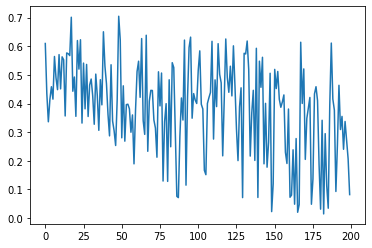

In [62]:
plt.plot(np.arange(len(loss_value)), loss_value)
plt.show()

In [63]:
def test(params, dataset):
    loss_value, (t_first_spike, spikes) = jax.vmap(loss_fn, in_axes=(None, 0))(params, dataset)
    accuracy = np.argmin(dataset[1], axis=-1) == np.argmin(t_first_spike, axis=-1)
    return np.mean(accuracy)

test(params, dataset)

DeviceArray(0.935, dtype=float32)

Seems like the training is working well. Todo:

* add optax